In [1]:
# import useful modules and packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from scipy import signal
from sklearn import linear_model

# Flu syndrome Data

### Reading data from the csv file

In [2]:
df_grippal = pd.read_csv('Openhealth_S-Grippal.csv', sep=';', na_values=0, decimal=',')
df_grippal.head()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


Looking at the Periode column, it's clear that the data sampling frequency is daily.

In [3]:
df_grippal.tail()

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
1747,2014-04-13,77.9,1.8,NaN
1748,2014-04-14,2.7,1.7,NaN
1749,2014-04-15,1.0,1.6,NaN
1750,2014-04-16,1.6,1.6,NaN
1751,2014-04-17,0.4,1.6,NaN


The sampling starts at the date 2009-07-1 and ends at 2014-04-17, covering almost a five years period.

## Replacing NaN data
We will only work with the IAS_brut variable. Let's observe if there is any NaN values for this variable.

In [4]:
print('There is {} null values'.format(df_grippal['IAS_brut'].isnull().sum()))

df_grippal[df_grippal['IAS_brut'].isnull()]

There is 8 null values


,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
340,2010-06-06,NaN,0.8,1.4
378,2010-07-14,NaN,0.7,0.3
627,2011-03-20,NaN,2.4,3.3
732,2011-07-03,NaN,0.8,0.3
858,2011-11-06,NaN,2.6,3.1
1062,2012-05-28,NaN,0.9,1.3
1075,2012-06-10,NaN,1.6,0.6
1502,2013-08-11,NaN,0.5,1.0


A more "reasonable" value at these unobserved dates could be the average of the two closest observed dates.

In [5]:
missing_values_indexes = df_grippal[df_grippal['IAS_brut'].isnull()].index

for missing_value_index in missing_values_indexes:
    prev_date_value = df_grippal.loc[missing_value_index - 1]['IAS_brut']
    next_date_value = df_grippal.loc[missing_value_index + 1]['IAS_brut']
    # Average of the two closest values
    df_grippal.at[missing_value_index, 'IAS_brut'] = (prev_date_value + next_date_value)/2

df_grippal.iloc[missing_values_indexes]

,PERIODE,IAS_brut,IAS_lisse,Incidence_Sentinelles
340,2010-06-06,0.80,0.8,1.4
378,2010-07-14,0.75,0.7,0.3
627,2011-03-20,2.15,2.4,3.3
732,2011-07-03,0.55,0.8,0.3
858,2011-11-06,2.75,2.6,3.1
1062,2012-05-28,6.10,0.9,1.3
1075,2012-06-10,1.75,1.6,0.6
1502,2013-08-11,0.55,0.5,1.0


## Drawing the time serie

We can draw the time serie considered as a function of time.

In [6]:
df_grippal = df_grippal[['PERIODE', 'IAS_brut']].set_index('PERIODE')
df_grippal.head()

,IAS_brut
PERIODE,
2009-07-01,1.7
2009-07-02,3.4
2009-07-03,2.1
2009-07-04,1.3
2009-07-05,14.2


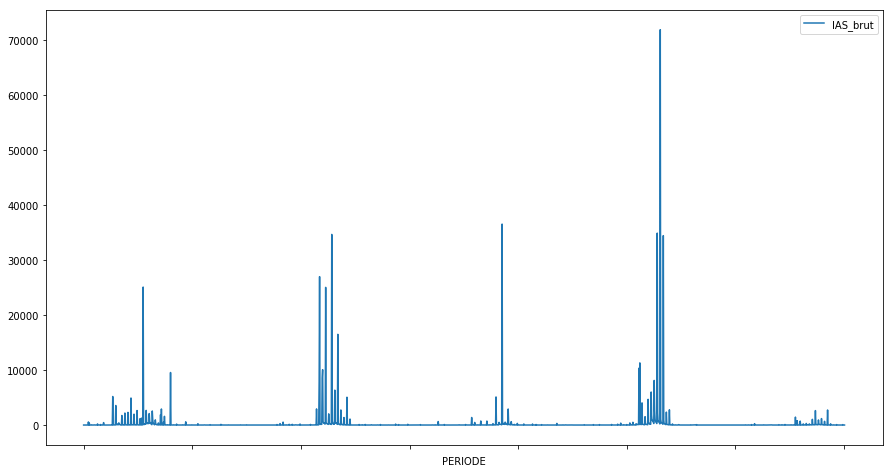

In [7]:
df_grippal.plot(figsize=(15,8))
plt.show()

**Observations**: as IAS stands for "advanced health indicators" in french, we look at the global flu impact on the french population approximately over a 5 years period. It's clear to assume that the IAS peaks refers to the years' winter periods, when the flu actually affects people!

## Histogram

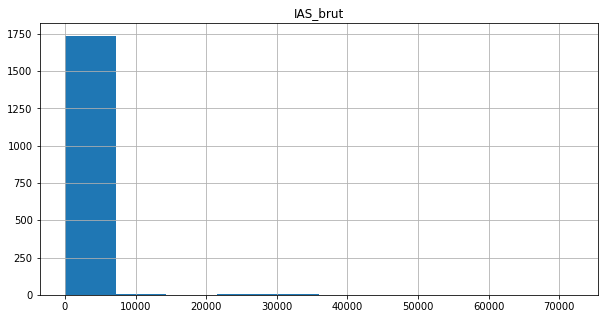

In [8]:
df_grippal.hist(figsize=(10,5))
plt.show()

**Observations**: The first bin is actually very big in front of the others. This corresponds to the period where the IAS is actually pretty low. This contributes to the flat aspect of the series in the previous plot. The few peaks in the IAS plot correspond then to an undesirable very large variance. We may apply a log transformation as we would like to stabilize the variance across time.

## Log transformation

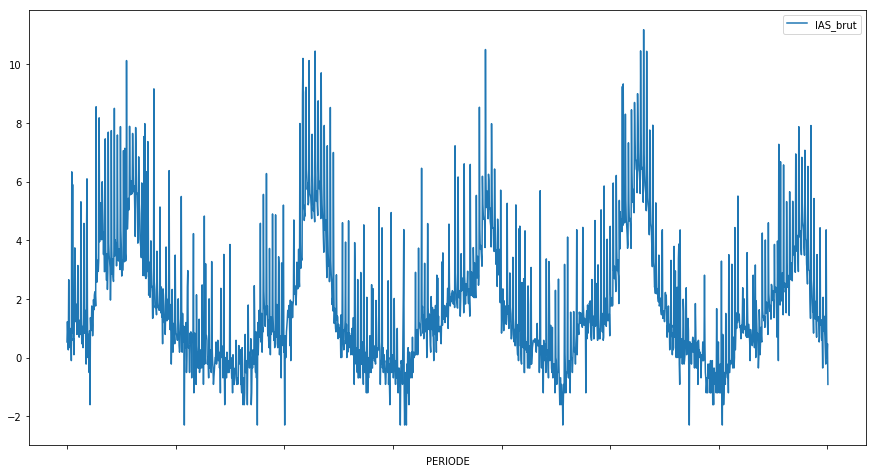

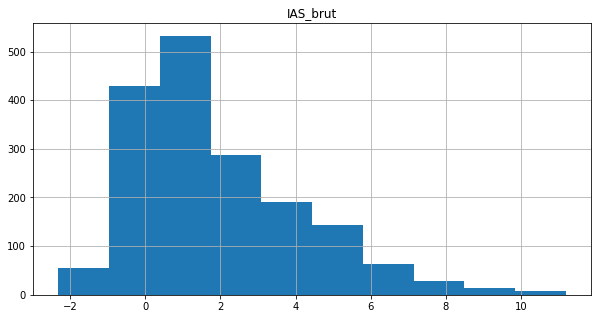

In [9]:
# Log transformation
df_grippal['IAS_brut'] = np.log(df_grippal['IAS_brut'])

df_grippal.plot(figsize=(15,8))
plt.show()

df_grippal.hist(figsize=(10,5))
plt.show()

**Observations**: After the log transformation, is clear that the variance is muche more stabilized across time. The data is more distributed in the histogram, and even some periodic effect may be identified on the plot. 

## Data periodogram
We may plot the periodogram for our data to observe frenquency peaks, corresponding to maybe some periodic trend in our observations.

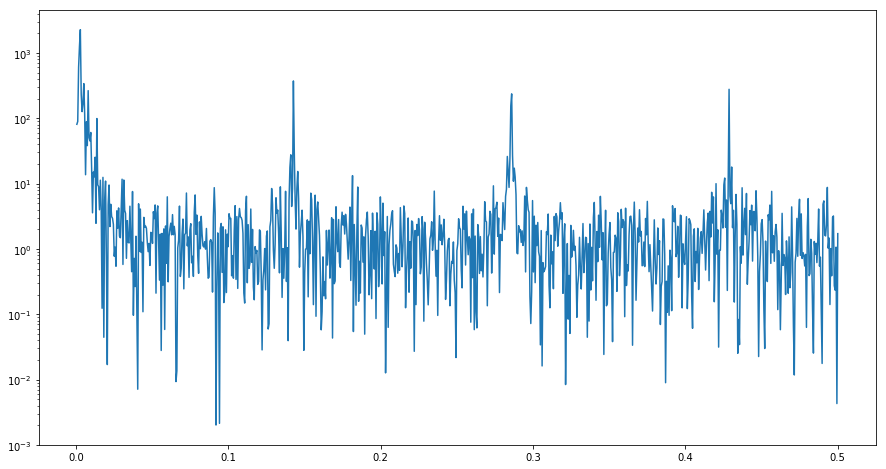

In [10]:
f, Pxx_den = signal.periodogram(df_grippal['IAS_brut'])
plt.figure(figsize=(15,8))
plt.semilogy(f[1:], Pxx_den[1:])
plt.show()

**Observations**: You could notice that there are several peaks for the spectral density. One can guess a year-wide trend and monthly periodic trend for early peaks, and also a periodic trend at the week scale for the peak around frequency 0.14 for example.

## Removing periodical trend of 1 year

To suppress a periodic trend of period $T$ in a signal $(x_t)_{t∈Z}$, you have to apply the filter $ΔT$ defined by $[ΔTx]_t = x_t - x_{t-T}$  
For one year period $T = 365$ (as the day is the unit here).

In [11]:
# One year period
T = 365

print('frequency corresponding to one year T period: {}'.format(1/T))
print('First periodogram frequenccies:')
print(f[1:10])

frequency corresponding to one year T period: 0.0027397260273972603
First periodogram frequenccies:
[0.00057078 0.00114155 0.00171233 0.00228311 0.00285388 0.00342466
 0.00399543 0.00456621 0.00513699]


By looking to the frequencies array, we find the index corresponding to the one year frenquency: 5.  
That permits to observe the value of the power spectral density for this one year frenquency before applying the filter.

In [12]:
print('Power spectral density for one year frenquency before removing periodic trend: {}'.format(Pxx_den[5]))

Power spectral density for one year frenquency before removing periodic trend: 2263.752980986104


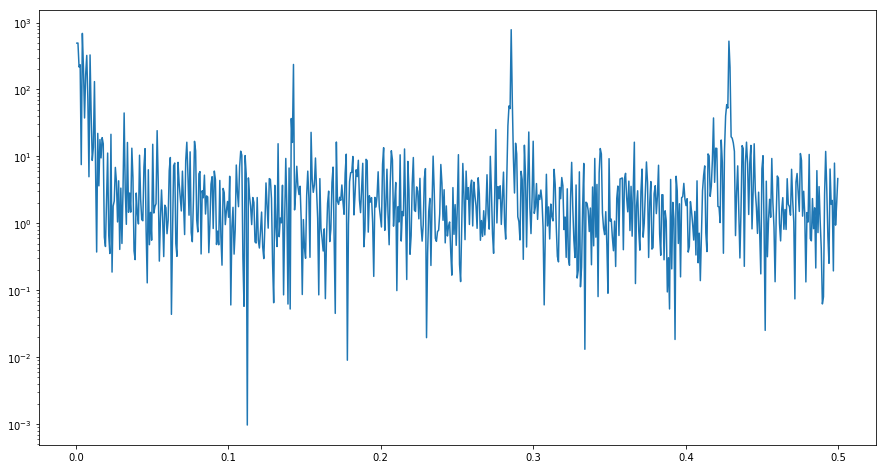

Power spectral density for one year frenquency after removing periodic trend: 7.544479733340064


In [13]:
# Getting filtered data
diff = []
for i in range(T, len(df_grippal)):
    diff.append(df_grippal['IAS_brut'].iloc[i] - df_grippal['IAS_brut'].iloc[i - T])

# Periodogram plot
f, Pxx_den = signal.periodogram(diff)
plt.figure(figsize=(15,8))
plt.semilogy(f[1:], Pxx_den[1:])
plt.show()

print('Power spectral density for one year frenquency after removing periodic trend: {}'.format(Pxx_den[5]))

**Observations**: Year and maybe monthly-wide periodic trends have been removed as some peaks for low frequency have disappeared!  
An other hint that the filter has been effective is that the power spectral density for the one year frenquency has been drastically reduced.

## Prediction from periodic trend

Instead of removing it, we could use this periodic trend to make a prediction, and estimate this periodic trend. 
  
The idea is to fit a linear reggression on the data, by adding some explanatory variables.

For each *k = 1,2, ... n_harm*, we may add two explanatory variables $x_{i,2k-1} = cos(t_i · k · 2π T)$ and $x_{i,2k} = sin (t_i · k · 2π T)$, where $t_i$ is the moment in time (we wil use integers instead of dates) and $T = 365$

In [14]:
# Function returning X_train, y_train and X_test
# for a training period t_train
# and a prediction period t_pred
# with n_harm for the number of harmonics

def predictionFromPeriodicTrend(t_train, t_pred, n_harm):
    X_train = np.zeros((len(t_train),2*n_harm))
    X_test = np.zeros((len(t_pred),2*n_harm))
    
    for k in range(0, n_harm):
        X_train[:,2*k] = np.cos(t_train * 2*(k+1)*math.pi / T)
        X_train[:,2*k + 1] = np.sin(t_train * 2*(k+1)*math.pi / T)
        X_test[:,2*k] = np.cos(t_pred * 2*(k+1)*math.pi / T)
        X_test[:,2*k + 1] = np.sin(t_pred * 2*(k+1)*math.pi / T)
        
    y_train = df_grippal['IAS_brut'].iloc[t_train-1]
    
    return X_train, y_train, X_test

We will use values from July 1, 2009 to March 31, 2013 to train the model, and then make a prediction for the whole period.

In [15]:
t_train = np.arange(1,1370)
t_pred = np.arange(1,1753)

Now we can draw the values of the time series and compare it to our prediction for the dataset. Several values for n_harm can be tested.

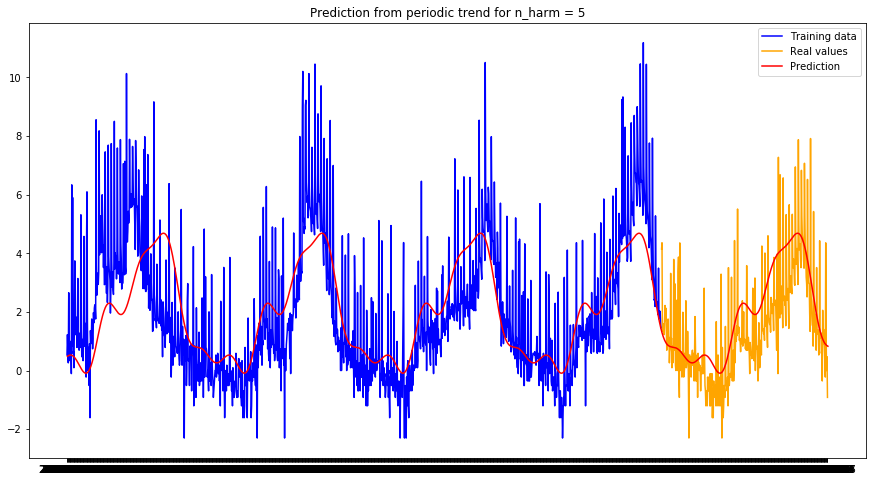

Mean square prediction error: 1.8974238369356464


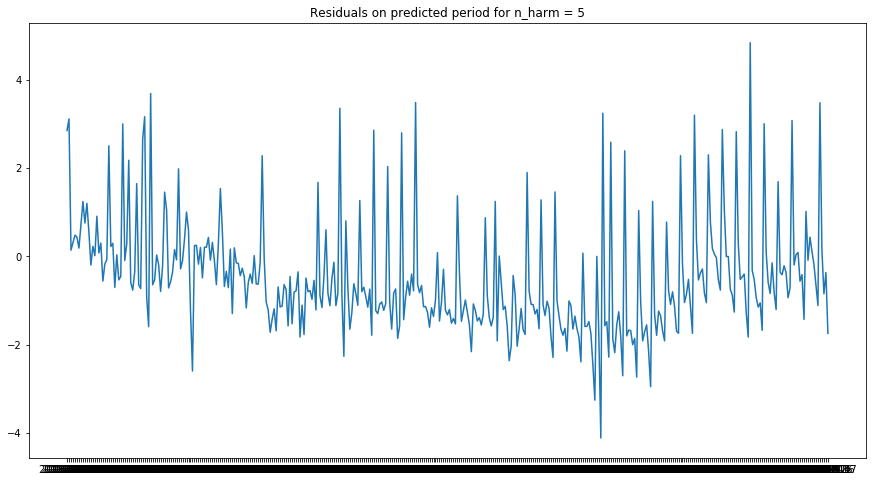

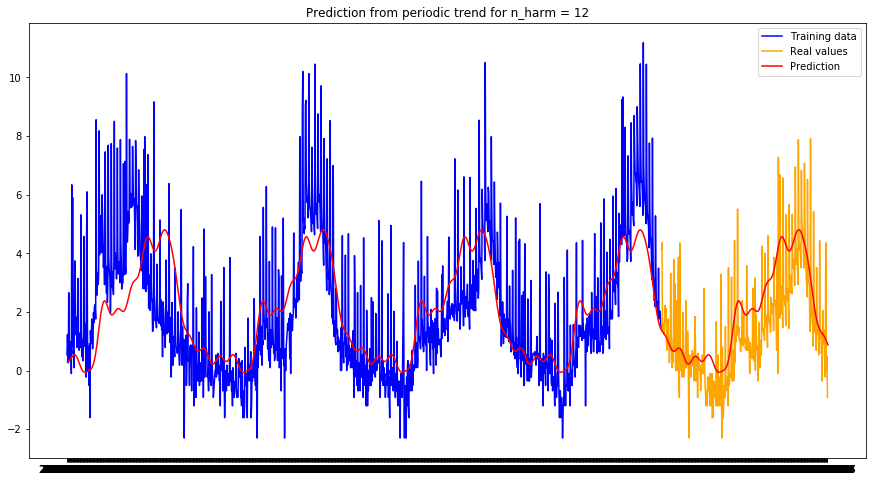

Mean square prediction error: 1.8826220818852992


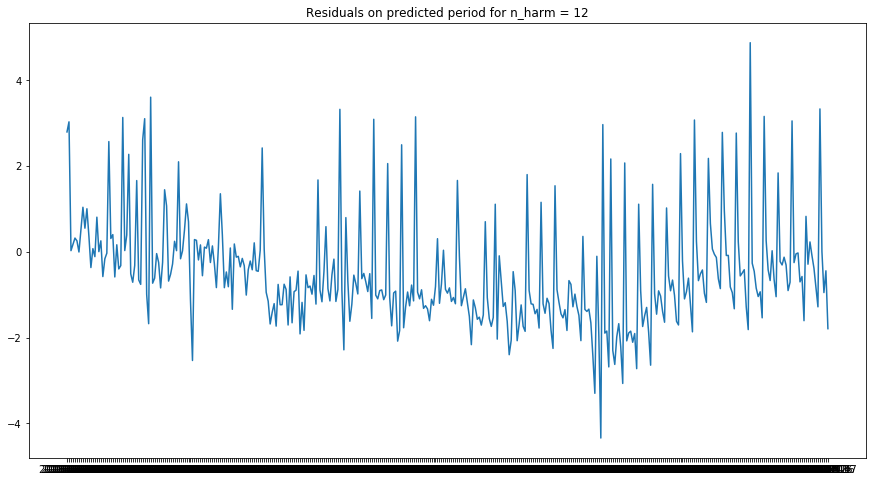

In [16]:
harm = [5, 12]

for n_harm in harm:
    
    # Getting explanatory variables for train and prediction
    X_train, y_train, X_test = predictionFromPeriodicTrend(t_train, t_pred, n_harm)

    # Fitting linear regression model with the new explanatory variables
    model = linear_model.LinearRegression()
    model.fit(X_train, y_train)
    regr_predict = model.predict(X_test)

    # Time series and prediction plot
    plt.figure(figsize=(15,8))
    plt.title('Prediction from periodic trend for n_harm = {}'.format(n_harm))
    plt.plot(df_grippal['IAS_brut'].iloc[t_train-1], 'b-', label='Training data')
    plt.plot(df_grippal['IAS_brut'].iloc[t_train[-1]:], '-', color='orange', label='Real values')
    plt.plot(t_pred, regr_predict, 'r-', label='Prediction')
    plt.legend()
    plt.show()
    
    # Residuals and MSE
    residuals = df_grippal['IAS_brut'].iloc[t_train[-1]:] - regr_predict[t_train[-1]:]
    MS_Prediction_error = np.mean(residuals**2)
    print('Mean square prediction error: {}'.format(MS_Prediction_error))
    
    # Residuals plot
    plt.figure(figsize=(15,8))
    plt.title('Residuals on predicted period for n_harm = {}'.format(n_harm))
    plt.plot(residuals)
    plt.show()

**Observations**: The prediction using only the annual periodic trend isn't so bad on the orange predicted part. With a greater number of harmonics, the mean square error is sligthly better. At least, we get a global trend for our prediction.  
However, the variance in the residuals doesn't seem rather constant over time. They are not really centered as well. We are right to think that this annual trend is really important for our model, but the residual observation makes us think that there is some other information that is not captured by this limited model.